# How to Master The Subtle Art of Train And Test Set Generation
## There is more to it than vanilla `train_test_split` function
<img src='images/jump.jpg'></img>
<figcaption style="text-align: center;">
    <strong>
        Photo by 
        <a href='https://www.pexels.com/@mary-taylor?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Mary Taylor</a>
        on 
        <a href='https://www.pexels.com/photo/active-man-jumping-from-brick-wall-6009265/?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Pexels</a>
    </strong>
</figcaption>

### Setup

In [34]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Base libraries
import time
import datetime
import os

# Scientific libraries
import numpy as np
import pandas as pd
from empiricaldist import Cdf, Pmf

# Visual libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import missingno as msno  # Visualize missing values

# Helper libraries
from tqdm.notebook import tqdm, trange
from colorama import Fore, Back, Style
import warnings
warnings.filterwarnings('ignore')

# Visual setup
import matplotlib.ticker as ticker
plt.style.use('ggplot')
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['figure.figsize'] = [12, 9]
rcParams['font.size'] = 16
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
custom_colors = ['#111111','#161616','#1c1c1c','#E31C25','#BB000E']
sns.set_palette(custom_colors)
%config InlineBackend.figure_format = 'retina'
%config Completer.use_jedi = False

# Pandas options
pd.set_option('max_colwidth', 40)
pd.options.display.max_columns = None  # Possible to limit
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Seed value for numpy.random
np.random.seed(42)

### Introduction

Arguably, the first function you learned from Scikit-learn is `train_test_split`. It performs the most basic yet a crucial task: diving the data into train and test sets. You fit the relevant model to the training set and test its accuracy on the test set. Sounds simple. But let me tell you, it is not simple. Not simple at all.

Scikit-learn provides a whopping amount of [15 different functions](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) to split your data depending on different use-cases. Some of them you never heard of, some of them are used daily. But don't worry, we won't cover all of them here. Instead, we will only focus on the most common and important ones used by scientists ranging from beginner to Kaggle Grandmasters. Specifically, you will learn the most important parameter of `train_test_split` for classification tasks, in other words - stratifying and how to perform cross-validation using `cross_validate`, `cross_val_score` and `StratifiedKFold`.

### Still need a clarification for `train_test_split`?

For complete starters, let me elaborate on the `train_test_split`. Suppose we want to predict the price of a diamond depending on its several attributes like carat and the length of its dimensions. As sample data, we will load the `diamonds` dataset from Seaborn:

In [49]:
diamonds = sns.load_dataset('diamonds')
diamonds

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


The dataset has several numerical and three categorical features. Since we want to predict continuous values, we can choose any regression algorithm, like `RandomForestRegressor` for the task.

For all ML algorithms, there is a single, clearly defined process: divide the data into training and testing sets, fit the model on the training set and test accuracy on the test set. The reason models are not trained on all of the data is that we mostly care about how a model performs on unseen data. And almost always, you won't have enough brand-new, real-world data to test. So, the only option is to put aside some of the available data for testing. Read more about training and testing process [here](https://towardsdatascience.com/codeless-machine-learning-dictionary-for-dummies-fa912cc7bdfe).

The splitting task can be done using Scikit-learn's `train_test_split` function. Below, we choose the variables to be used to predict the diamond prices as features (*X* array) and the prices itself as the target (*y* array):

In [8]:
from sklearn.model_selection import train_test_split

# Create features and target arrays
X = diamonds[['carat', 'table', 'depth']]
y = diamonds.price

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=1121218)

The function is imported from `sklearn.model_selection`. For the first 2 arguments, we pass the feature array first and then, target array. The size of the test set is specified with `test_size` argument - here we are setting aside 30% of the data for testing. `random_state` is seeded so we get consistent results every time we run the function with the same arguments.

We unpack the output into 4 variables. I want you to note the order of the outputs because it is easy to mix them.

Next, we will fit a `RandomForestRegressor` model with default parameters and score it:

In [11]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
forest = RandomForestRegressor()

# Fit to the training
forest.fit(X_train, y_train)

# Print the training score
print("The coefficient of determination for the training set:", forest.score(X_train, y_train))
print("The coefficient of determination for the test set:", forest.score(X_test, y_test))

RandomForestRegressor()

The coefficient of determination for the training set: 0.9595220664760806
The coefficient of determination for the test set: 0.8688296178173177


That's is the basic usage of `train_test_split` for regression. But things will get more interesting if we include categoricals into the mix.

### Sampling Bias
Before I explain how to use `train_test_split` for categorical features, I have to briefly mention *sampling bias*. Sampling bias occurs when the chosen sample is not representative of the population. For example, an ice-cream company may call 1000 people to find out what ice-cream flavors they like. Not to create a sampling bias, or in other words, to choose a representative ratio, the surveyors should respect the ration of males and females in the given area or city. If there are 54% males and 46% females in the area, the company has to make sure to survey 540 men and 460 women to get a representative sample. 

When we split the data into training and test sets, we are essentially taking samples from the population. So, whenever there are categorical variables involved, we should split the data in a way that keeps the underlying proportion of categories the same or close to same.

Formally, this type of sampling is called *stratified sampling* and each unique category is called a *strata*. Next, we will see how can use this method in code.

### Stratified Splits With `train_test_split`

Stratified sampling is super easy in Scikit-learn, just add `stratify=feature_name` parameter to the function. To prove this works, let's split diamonds dataset both with vanilla splits and stratification. 

In [35]:
# Build feature and target
X = diamonds.select_dtypes(include='category')
y = diamonds.price

# Vanilla split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=1121218)

This time, we are only using the categorical variables. Let's see the proportion of categories in both `X` and `X_train`:

In [36]:
X['clarity'].value_counts(normalize=True)

SI1     0.242214
VS2     0.227253
SI2     0.170449
VS1     0.151483
VVS2    0.093919
VVS1    0.067760
IF      0.033185
I1      0.013737
Name: clarity, dtype: float64

In [37]:
X_train['clarity'].value_counts(normalize=True)

SI1     0.242915
VS2     0.227846
SI2     0.171513
VS1     0.150246
VVS2    0.093358
VVS1    0.067456
IF      0.033053
I1      0.013613
Name: clarity, dtype: float64

You would think that the differences in proportions are not that great. But even the tiniest fractional change can throw off a model when it comes to predictions. Here is a clear example of this:

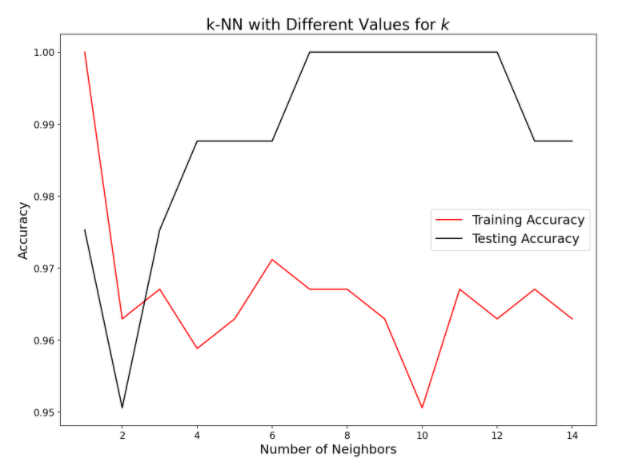

Above is a model complexity curve of a kNN classifier that was trained and tested on a vanilla split. As you can see, almost all testing scores are higher than training. Here is the result after the model was retrained on a stratified split:

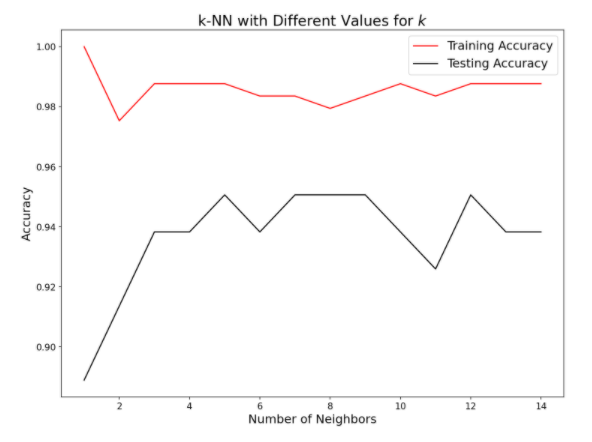

You can see how vastly stratification changes the performance of a model. 

> Generally, when you see a testing score higher than training, don't be overexcited that you built something exceptional. It is the exact opposite, somewhere along the way you made a blunder😁🤦‍♂️. 

Here is how you can split the data by stratifying on the diamond's cut:

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=X['cut'], random_state=1121218)

In [43]:
X['cut'].value_counts(normalize=True)

Ideal        0.399537
Premium      0.255673
Very Good    0.223990
Good         0.090953
Fair         0.029848
Name: cut, dtype: float64

In [44]:
X_train['cut'].value_counts(normalize=True)

Ideal        0.399544
Premium      0.255681
Very Good    0.223979
Good         0.090948
Fair         0.029848
Name: cut, dtype: float64

Setting the `stratify` to a categorical feature (or the target if you are doing classification, i. e. `stratify=y`) ensures that split is done to preserve the proportion of categories in the passed column. As you can see, the proportions are preserve to 4th decimal place.